In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional
import pandas as pd
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


### Audiorecordings(from lectures)

dict_keys(['speaker_embedding', 'specgram', 'melfilterbank', 'mfcc', 'sample_rate', 'opensmile'])


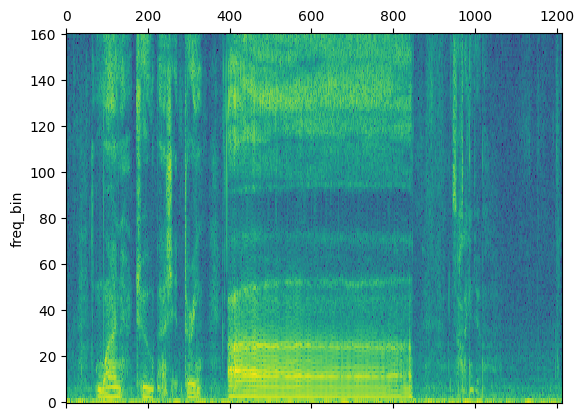

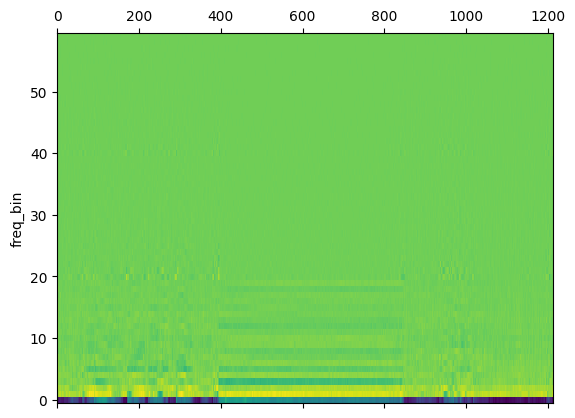

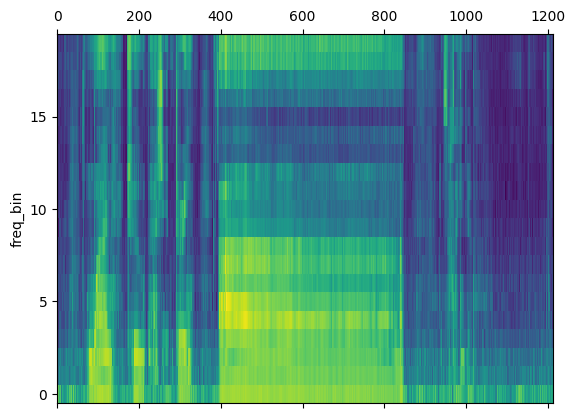

In [3]:
dataset = VBAIDataset('../bids_with_sensitive_recordings')
path = '../bids_with_sensitive_recordings/sub-9c6e4508-5a33-4e3c-9058-b21503c5966e/ses-291F92AC-4B67-4A6E-9AE2-6ACB15772371/audio/sub-9c6e4508-5a33-4e3c-9058-b21503c5966e_ses-291F92AC-4B67-4A6E-9AE2-6ACB15772371_Prolonged-vowel_rec-Prolonged-vowel'
data = torch.load(path + '.pt')
melfilterbank = data["melfilterbank"]
print(data.keys())
mfcc = data["mfcc"]
pt_spec = data["specgram"]
audio = Audio.from_file(path + '.wav')
audio = audio.to_16khz()
win_length = 20
hop_length = 10
nfft = None
features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10))).T
pt_features_specgram = 10.0 * torch.log10(torch.maximum(pt_spec, torch.full(pt_spec.size(), fill_value=1e-10))).T
plot_spectrogram(features_specgram)
plot_spectrogram(mfcc.T)
plot_spectrogram(melfilterbank.T)

### Dataset / diagnosis extraction

In [148]:
# loading the dataset
dataset = VBAIDataset('../bids_with_sensitive_recordings/')

target_diagnosis = 'airway_stenosis' #airway_stenosis

In [149]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

In [150]:
qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].drop_duplicates(subset='recording_session_id')

person_session_pairs.reset_index(drop=True, inplace=True)

print('Found {} person/session pairs'.format(len(person_session_pairs)))

Found 204 person/session pairs


In [151]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
participant_df = participant_df[['record_id', target_diagnosis]]
participant_df.shape

(178, 2)

In [152]:
Train1 = pd.merge(person_session_pairs, participant_df, on='record_id', how='inner')
Train1.shape

(204, 3)

### Demographics

In [153]:
dg = pd.read_csv('../demographics.csv')
dg = dg[(pd.notna(dg['household_income_usa']) | pd.notna(dg['household_income_ca'])) &
                                   (~((dg['household_income_usa'] == 'Prefer not to answer') | 
                                      (dg['household_income_ca'] == 'Prefer not to answer')))]
pre_train_labeled = pd.DataFrame(dg[["record_id", "demographics_session_id"]])

for index, row in dg.iterrows():
    if pd.notna(dg.loc[index, "household_income_usa"]) and dg.loc[index, "household_count"] >= 3: # USD; HH >= 3
        income = dg.loc[index, "household_income_usa"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
    
    elif pd.notna(dg.loc[index, "household_income_usa"]): # USD; HH < 3
        income = dg.loc[index, "household_income_usa"]
        if income in ['< $15,000']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$15,000 to $29,999', '$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$100,000 to $149,999', '$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
        
    elif pd.notna(dg.loc[index, "household_income_ca"]):  # CA; HH >= 3
        income = dg.loc[index, "household_income_ca"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_ca")
    else:
        print(index)

In [154]:
Train = pd.merge(Train1, pre_train_labeled, on='record_id', how='left')
columns_to_fill = ['demographics_session_id', 'SES']
Train[columns_to_fill] = Train[columns_to_fill].fillna(-1)
columns_to_check = ["record_id", "recording_session_id"]
Train = Train.drop_duplicates(subset=columns_to_check, keep='first')
Train[(Train[target_diagnosis] == True) & (Train['SES'] == 2.0)]

,record_id,recording_session_id,airway_stenosis,demographics_session_id,SES
4,022c62b4-1b02-43f1-90cf-301b61eb406c,653DCE31-88E0-4937-A1E9-178C2E08D204,True,653DCE31-88E0-4937-A1E9-178C2E08D204,2.0
5,022c62b4-1b02-43f1-90cf-301b61eb406c,CFB7788D-0ED6-49A8-9935-D66C5A4EFDB2,True,653DCE31-88E0-4937-A1E9-178C2E08D204,2.0
12,149f5b8a-aa7e-4806-9025-606c9fac95a2,C81204E5-FF3D-465E-9B4D-06A769616048,True,C81204E5-FF3D-465E-9B4D-06A769616048,2.0
13,15943fd6-c8ba-48b7-a754-ab15a9781831,FAC15A71-AF37-496F-868A-D7927E8C89E6,True,FAC15A71-AF37-496F-868A-D7927E8C89E6,2.0
32,2c95136b-0efb-4d67-8fdf-113a8af5ac12,3596D51F-73B0-47AE-BFAB-08FE8A2B9295,True,3596D51F-73B0-47AE-BFAB-08FE8A2B9295,2.0
83,72bd9f6a-134f-4a4f-8e31-5ded9e52d25b,4ABBC3F3-A890-4549-96BD-DEC5D55CBB77,True,4ABBC3F3-A890-4549-96BD-DEC5D55CBB77,2.0
112,92aa646d-f022-4b91-802f-854e1cbd444f,C63E6402-5ECC-45B5-8A57-6FE638A766A5,True,C63E6402-5ECC-45B5-8A57-6FE638A766A5,2.0
116,9a657e0d-2416-4af8-bf88-5ad2e15f2641,FD7F03F1-04D2-4718-89D4-CDD1594C9B72,True,FD7F03F1-04D2-4718-89D4-CDD1594C9B72,2.0
127,a58d1e3f-dc63-4211-ab71-ad0a2797733c,9829C772-79B5-4BE0-AFB4-A6D8EE0DDB31,True,9829C772-79B5-4BE0-AFB4-A6D8EE0DDB31,2.0
134,b076f63b-b218-4549-a531-7c33652de45b,712358D9-5E5E-47E7-94EB-3EBBC580868D,True,712358D9-5E5E-47E7-94EB-3EBBC580868D,2.0


In [155]:
X = Train[['record_id', 'recording_session_id', 'SES']]
y = Train[[target_diagnosis]]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

print("train", y_train[target_diagnosis].value_counts())
print("validation", y_val[target_diagnosis].value_counts())
print("test", y_test[target_diagnosis].value_counts())

print("train", X_train['SES'].value_counts())
print("validation", X_val['SES'].value_counts())
print("test", X_test['SES'].value_counts())

train airway_stenosis
False    111
True      52
Name: count, dtype: int64
validation airway_stenosis
False    14
True      6
Name: count, dtype: int64
test airway_stenosis
False    14
True      7
Name: count, dtype: int64
train SES
-1.0    59
 1.0    36
 2.0    33
 3.0    24
 0.0    11
Name: count, dtype: int64
validation SES
 2.0    6
-1.0    5
 3.0    4
 1.0    3
 0.0    2
Name: count, dtype: int64
test SES
-1.0    8
 2.0    4
 1.0    4
 3.0    3
 0.0    2
Name: count, dtype: int64


### Dataset

In [156]:
# rainbow, story recall, Picture description
class RainbowMelfilterBankDatasetWithMultisampling(torch.utils.data.Dataset):
	def __init__(self, data, segment_size):
		self.segment_size = segment_size
		self.data = data
		self.data[target_diagnosis] = self.data[target_diagnosis].astype(float)
		self.data.reset_index(drop=True, inplace=True)
		
		# get location for every recording of rainbow passage // generate multiple samples per recording
		index = 0
		while index < len(self.data):
			row = self.data.iloc[index]
			if not pd.notna(row['record_id']):
				self.data = self.data.drop(index = index)
				self.data.reset_index(drop=True, inplace=True)
				# index += 1
				display("dropped", row)
				continue
			subject = "sub-" + row['record_id']
			session = "ses-" + row['recording_session_id']
			location = str("../bids_with_sensitive_recordings/" + subject + "/" + session + '/audio/'+subject+"_"+session+"_Rainbow-Passage_rec-Rainbow-Passage")
			if os.path.exists(location + '.wav'):
				self.data.at[index, "location"] = location
				self.data.at[index, "segment"] = 0
				audio = Audio.from_file(location+".wav")
				audio = audio.to_16khz().signal.squeeze()
				num_segments = audio.size(0) // 160 // self.segment_size #audio size mapping to spectrogram size
    			#insert num_segment rows with different segment number(each record is different timeframe of the same recording)
				count = 1
				while count < num_segments:
					row_to_copy = self.data.iloc[index]
					row_df = pd.DataFrame([row_to_copy])
					self.data = pd.concat([self.data.iloc[:index+1], row_df, self.data.iloc[index+1:]]).reset_index(drop=True)
					index += 1
					self.data.at[index, "segment"] = count
					count += 1

			else:
				# print all patients without Rainbow passage recording   
				print("Location does not exist ", location)
				data.at[index, "location"] = "DNE"
				self.data = self.data.drop(index = index)
				self.data.reset_index(drop=True, inplace=True)
				index-=1
			index += 1
		self.data.reset_index(drop=True, inplace=True)

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		if not os.path.exists(self.data.loc[idx, "location"]+'.pt'):
			display("error", self.data.loc[idx, "location"])
		torch_data = torch.load(self.data.loc[idx, "location"]+'.pt')
		melfilterbank = torch_data["melfilterbank"]
		
		seg_num = self.data.loc[idx, "segment"]
		max_seg_size = melfilterbank.size(0) // self.segment_size
  
		start = (melfilterbank.size(0) - self.segment_size * max_seg_size) // 2
		start = int(start + self.segment_size * seg_num)

		melfilterbank = melfilterbank[start:start+self.segment_size, :]

		label = self.data.loc[idx, target_diagnosis]
  
		ses = self.data.loc[idx, 'SES']
		
		return {'signal': melfilterbank.T, 'label': label, 'SES': ses}

In [157]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_dataset = RainbowMelfilterBankDatasetWithMultisampling(train_df, 500)
val_dataset = RainbowMelfilterBankDatasetWithMultisampling(val_df, 500)
test_dataset = RainbowMelfilterBankDatasetWithMultisampling(test_df, 500)

print("Train dataset counts: ")
print(train_dataset.data[target_diagnosis].value_counts())
print("Validation dataset counts: ")
print(val_dataset.data[target_diagnosis].value_counts())
print("Test dataset counts: ")
print(test_dataset.data[target_diagnosis].value_counts())

print("Perform data check:")
check_loc_1 = train_dataset.data[~train_dataset.data['location'].str.endswith('Rainbow-Passage')].empty
check_loc_2 = val_dataset.data[~val_dataset.data['location'].str.endswith('Rainbow-Passage')].empty
check_loc_3 = test_dataset.data[~test_dataset.data['location'].str.endswith('Rainbow-Passage')].empty
if ~check_loc_1 and ~check_loc_2 and ~check_loc_3:
    print("\tAll locations are not NaN")
else:
    print("\tFound incorrect locations")
    
check_dublicates_1 = train_dataset.data[train_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
check_dublicates_2 = val_dataset.data[val_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
check_dublicates_3 = test_dataset.data[test_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
if ~check_loc_1 and ~check_loc_2 and ~check_loc_3:
    print("\tNo dublicates were generated")
else:
    print("\tCheck dublicated values!")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=18, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=6, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=6, shuffle=False)

for batch in val_dataloader:
    print(batch['signal'].shape)
    break

Location does not exist  ../bids_with_sensitive_recordings/sub-eed0e4a4-c915-4ada-9d23-9e0c56fa0d37/ses-BDC578CA-C29F-4736-B838-6E11462650D8/audio/sub-eed0e4a4-c915-4ada-9d23-9e0c56fa0d37_ses-BDC578CA-C29F-4736-B838-6E11462650D8_Rainbow-Passage_rec-Rainbow-Passage
Location does not exist  ../bids_with_sensitive_recordings/sub-6980ce82-b88d-4c5b-b6a6-8ed166dc9eb3/ses-0923200E-5774-40CF-AF67-4507AD1C650E/audio/sub-6980ce82-b88d-4c5b-b6a6-8ed166dc9eb3_ses-0923200E-5774-40CF-AF67-4507AD1C650E_Rainbow-Passage_rec-Rainbow-Passage
Location does not exist  ../bids_with_sensitive_recordings/sub-e5db3e0c-6589-4a15-a5e7-8a95e4ed34a5/ses-9B9C2C1A-5ABB-4D10-8A1C-D82B55453EB3/audio/sub-e5db3e0c-6589-4a15-a5e7-8a95e4ed34a5_ses-9B9C2C1A-5ABB-4D10-8A1C-D82B55453EB3_Rainbow-Passage_rec-Rainbow-Passage
Location does not exist  ../bids_with_sensitive_recordings/sub-b0447797-b571-436d-9d6e-bbff73bcc2de/ses-91D1C2FA-A44B-441F-8EB7-97CB5E3E2AA2/audio/sub-b0447797-b571-436d-9d6e-bbff73bcc2de_ses-91D1C2FA-A44B

In [158]:
train_class0_count = (y_train == 0).sum()
train_class1_count = (y_train == 1).sum()
class_counts = [train_class0_count, train_class1_count]
total_samples = sum(class_counts)
class_weights = [total_samples / (2 * count) for count in class_counts]
weights = torch.tensor(class_weights, dtype=torch.float32)
print(weights[0])
print(weights[1])
pos_weight = weights[1]/ weights[0]

tensor([0.7342])
tensor([1.5673])


### CNN Model

In [159]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Conv1d(20, 64, kernel_size=9, stride=3, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.mp = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Calculate the input size to the first linear layer
        self.fc_input_size = self._calculate_fc_input_size()
  
        self.fc1 = nn.Linear(self.fc_input_size, 64)
        self.fc3 = nn.Linear(64, 1)  # One output neuron for binary classification

    def forward(self, x):
        x = self.mp(self.bn1(torch.nn.functional.relu(self.conv1(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(x)  # Apply dropout before the linear layers
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc3(x)  # sigmoid applied in BCEWithLogitsLoss
        return x

    def _calculate_fc_input_size(self):
        x = torch.randn(1, 20, 500)
        x = self.mp(self.bn1(torch.nn.functional.relu(self.conv1(x))))
        return x.view(x.size(0), -1).size(1)

In [160]:
cnn = CNN_1D()
_ = summary(cnn, (20, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 166]          11,584
       BatchNorm1d-2              [-1, 64, 166]             128
         MaxPool1d-3               [-1, 64, 83]               0
           Dropout-4                 [-1, 5312]               0
            Linear-5                   [-1, 64]         340,032
            Linear-6                    [-1, 1]              65
Total params: 351,809
Trainable params: 351,809
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.24
Params size (MB): 1.34
Estimated Total Size (MB): 1.62
----------------------------------------------------------------


In [161]:
def eval(model, dataloader):
    model.eval()
    acc = 0
    total = 0
    
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    all_predictions = []
    all_ground_truths = []
    for batch in dataloader:
        with torch.no_grad():
            outputs = torch.sigmoid(model(batch['signal'])).squeeze()
            predicted = (outputs >= threshhold).float()
            ground_truth = batch['label']
            acc += (predicted == ground_truth).sum().item()
            total += ground_truth.size(0)
            
            true_positives += ((predicted == 1) & (ground_truth == 1)).sum().item()
            true_negatives += ((predicted == 0) & (ground_truth == 0)).sum().item()
            false_positives += ((predicted == 1) & (ground_truth == 0)).sum().item()
            false_negatives += ((predicted == 0) & (ground_truth == 1)).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_ground_truths.extend(ground_truth.cpu().numpy().flatten())
            
    if true_positives + false_negatives > 0:
        accuracy_positive = true_positives / (true_positives + false_negatives)
    else:
        accuracy_positive = 0
    
    if true_negatives + false_positives > 0:
        accuracy_negative = true_negatives / (true_negatives + false_positives)
    else:
        accuracy_negative = 0
    
    average_accuracy = (accuracy_positive + accuracy_negative) / 2
    return average_accuracy, all_predictions, all_ground_truths

cnn = CNN_1D()
threshhold = 0.5
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

num_epochs = 15
best_val_acc = 0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    cnn.train()
    closs = []
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = cnn(batch['signal']).squeeze()
        loss = criterion(outputs, batch['label'])
        closs += [loss.item()] * len(batch['signal'])
        loss.backward()
        optimizer.step()
    scheduler.step()
    train_loss = sum(closs) / len(closs)
    train_losses.append(train_loss)
    
    val_acc, _, _ = eval(cnn, val_dataloader)
    val_losses.append(train_loss)
    val_accuracies.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn.state_dict(), 'mymodel.pth')
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, Val Acc: {val_acc}')

Epoch 1/15, Loss: 0.912958192608093, Val Acc: 0.7162962962962962
Epoch 2/15, Loss: 0.7057778670201669, Val Acc: 0.7066666666666667
Epoch 3/15, Loss: 0.6102923540197959, Val Acc: 0.72
Epoch 4/15, Loss: 0.5223366577637119, Val Acc: 0.6881481481481482
Epoch 5/15, Loss: 0.44484986876421245, Val Acc: 0.6118518518518519
Epoch 6/15, Loss: 0.3802593052889563, Val Acc: 0.6962962962962963
Epoch 7/15, Loss: 0.37368264537967255, Val Acc: 0.6962962962962963
Epoch 8/15, Loss: 0.3770741568541693, Val Acc: 0.6659259259259259
Epoch 9/15, Loss: 0.36913784509124964, Val Acc: 0.6844444444444444
Epoch 10/15, Loss: 0.35143172906562375, Val Acc: 0.6777777777777778
Epoch 11/15, Loss: 0.3585827292385084, Val Acc: 0.6711111111111111
Epoch 12/15, Loss: 0.35304620829620637, Val Acc: 0.6592592592592592
Epoch 13/15, Loss: 0.3535243361238322, Val Acc: 0.6777777777777778
Epoch 14/15, Loss: 0.3426611863486531, Val Acc: 0.6592592592592592
Epoch 15/15, Loss: 0.3374197764504745, Val Acc: 0.6644444444444444


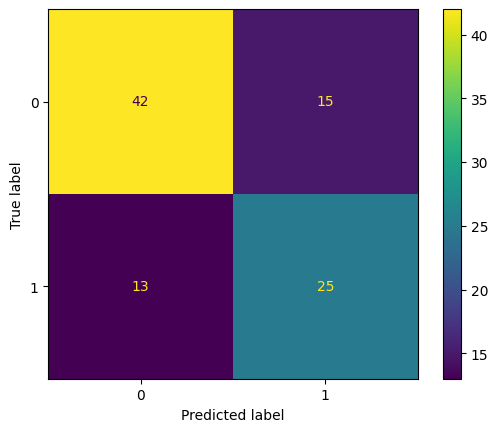

              precision    recall  f1-score   support

     Class 0       0.76      0.74      0.75        57
     Class 1       0.62      0.66      0.64        38

    accuracy                           0.71        95
   macro avg       0.69      0.70      0.70        95
weighted avg       0.71      0.71      0.71        95



In [162]:
_, predictions, ground_truths = eval(cnn, test_dataloader)
cm = confusion_matrix(ground_truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
report = classification_report(ground_truths, predictions, target_names=['Class 0', 'Class 1'])
print(report)

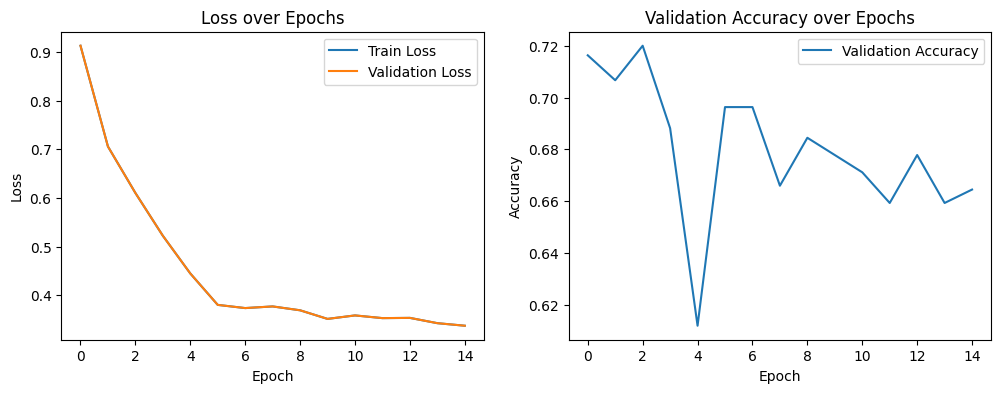

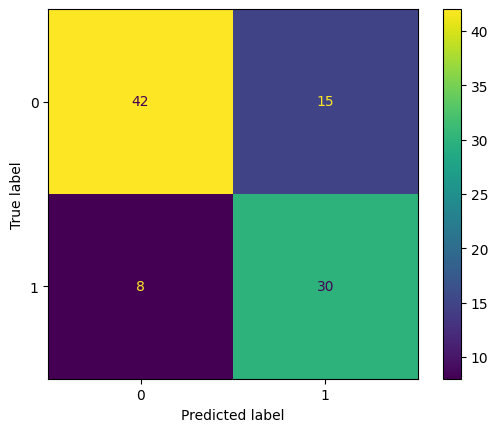

              precision    recall  f1-score   support

     Class 0       0.84      0.74      0.79        57
     Class 1       0.67      0.79      0.72        38

    accuracy                           0.76        95
   macro avg       0.75      0.76      0.75        95
weighted avg       0.77      0.76      0.76        95



In [163]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy over Epochs')
plt.show()

# Confusion matrix
cnn.load_state_dict(torch.load('mymodel.pth'))
_, predictions, ground_truths = eval(cnn, test_dataloader)

cm = confusion_matrix(ground_truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
report = classification_report(ground_truths, predictions, target_names=['Class 0', 'Class 1'])
print(report)

In [164]:
def analyze_test_predictions(model, test_dataloader):
    model.eval()
    all_test_values = []
    all_predictions = []
    all_ses = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            inputs = batch['signal']
            labels = batch['label']
            ses = batch['SES']
            
            outputs = torch.sigmoid(model(inputs)).squeeze()
            predicted = (outputs >= threshhold).float()
            
            all_test_values.extend(labels.cpu().numpy().flatten())
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_ses.extend(ses.cpu().numpy())
    
    # Create DataFrame
    df = pd.DataFrame({
        'Ses': all_ses,
        'test_value': all_test_values,
        'model_prediction': all_predictions
    })
    
    return df

df = analyze_test_predictions(cnn, test_dataloader)

In [165]:
df_undef = df[df['Ses'] == -1]
df_poverty = df[df['Ses'] == 0]
df_lower = df[df['Ses'] == 1]
df_middle = df[df['Ses'] == 2]
df_upper = df[df['Ses'] == 3]

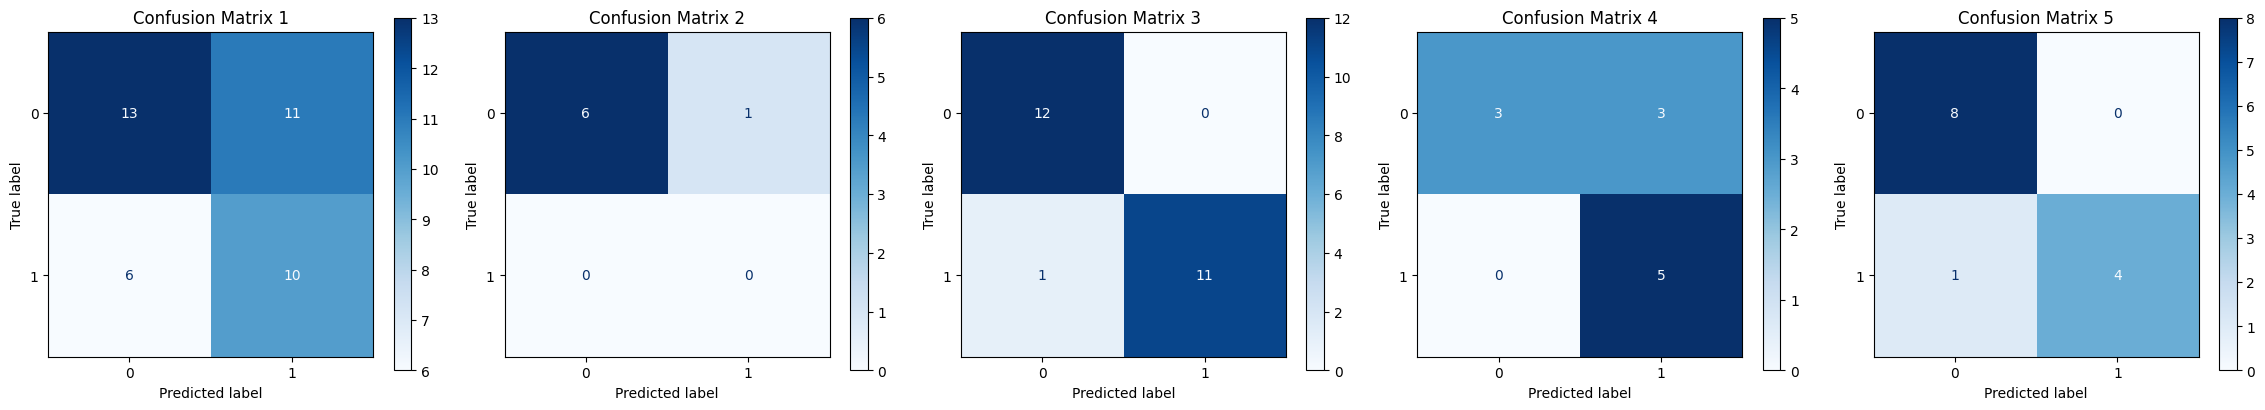

In [166]:
# Generate confusion matrices
cm1 = confusion_matrix(df_undef['test_value'], df_undef['model_prediction'])
cm2 = confusion_matrix(df_poverty['test_value'], df_poverty['model_prediction'])
cm3 = confusion_matrix(df_lower['test_value'], df_lower['model_prediction'])
cm4 = confusion_matrix(df_middle['test_value'], df_middle['model_prediction'])
cm5 = confusion_matrix(df_upper['test_value'], df_upper['model_prediction'])

# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(23, 4))

# Plot the first confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(ax=ax[0], cmap='Blues')
ax[0].title.set_text('Confusion Matrix 1')

# Plot the second confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(ax=ax[1], cmap='Blues')
ax[1].title.set_text('Confusion Matrix 2')

# Plot the second confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp2.plot(ax=ax[2], cmap='Blues')
ax[2].title.set_text('Confusion Matrix 3')

# Plot the second confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm4)
disp2.plot(ax=ax[3], cmap='Blues')
ax[3].title.set_text('Confusion Matrix 4')

# Plot the second confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm5)
disp2.plot(ax=ax[4], cmap='Blues')
ax[4].title.set_text('Confusion Matrix 5')

# Adjust layout
plt.tight_layout()
plt.show()